In [1]:
import sys
sys.path.append('..')

In [2]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

In [3]:
from collections import Counter

popular_interests = Counter(interest
                            for user_interests in users_interests
                            for interest in user_interests)
popular_interests.most_common()[:10]

[('Python', 4),
 ('R', 4),
 ('Big Data', 3),
 ('HBase', 3),
 ('Java', 3),
 ('statistics', 3),
 ('regression', 3),
 ('probability', 3),
 ('Hadoop', 2),
 ('Cassandra', 2)]

In [4]:
from typing import List, Tuple

def most_popular_new_interests(
        user_interests: List[str],
        max_results: int = 5) -> List[Tuple[str, int]]:
    suggestions = [(interest, frequency)
                   for interest, frequency in popular_interests.most_common()
                   if interest not in user_interests]
    return suggestions[:max_results]

In [5]:
most_popular_new_interests(["NoSQL","MongoDB","Cassandra","HBase","Postgres"],5)

[('Python', 4), ('R', 4), ('Big Data', 3), ('Java', 3), ('statistics', 3)]

In [6]:
unique_interests = sorted({interest
                           for user_interests in users_interests
                           for interest in user_interests})

assert unique_interests[:6] == [
    'Big Data',
    'C++',
    'Cassandra',
    'HBase',
    'Hadoop',
    'Haskell',
    # ...
]

In [7]:
def make_user_interest_vector(user_interests: List[str]) -> List[int]:
    """
    Given a list ofinterests, produce a vector whose ith element is 1
    if unique_interests[i] is in the list, 0 otherwise
    """
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

In [8]:
user_interest_vectors = [make_user_interest_vector(user_interests)
                         for user_interests in users_interests]

100%|██████████| 1000/1000 [00:00<00:00, 2876.62it/s]


[1.0,
 0.3380617018914066,
 0.0,
 0.0,
 0.0,
 0.1543033499620919,
 0.0,
 0.0,
 0.1889822365046136,
 0.5669467095138409,
 0.0,
 0.0,
 0.0,
 0.1690308509457033,
 0.0]

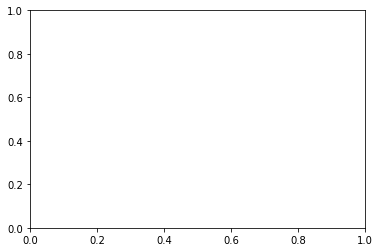

In [9]:
from scratch.nlp import cosine_similarity

user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_vectors]
                      for interest_vector_i in user_interest_vectors]

user_similarities[0]

In [10]:
# Users 0 and 9 share interests in Hadoop, Java, and Big Data
assert 0.56 < user_similarities[0][9] < 0.58, "several shared interests"

# Users 0 and 8 share only one interest: Big Data
assert 0.18 < user_similarities[0][8] < 0.20, "only one shared interest"

In [11]:
def most_similar_users_to(user_id: int) -> List[Tuple[int, float]]:
    pairs = [(other_user_id, similarity)                      # Find other
             for other_user_id, similarity in                 # users with
                enumerate(user_similarities[user_id])         # nonzero
             if user_id != other_user_id and similarity > 0]  # similarity.

    return sorted(pairs,                                      # Sort them
                  key=lambda pair: pair[-1],                  # most similar
                  reverse=True)                               # first.

In [12]:
most_similar_to_zero = most_similar_users_to(0)
user, score = most_similar_to_zero[0]
assert user == 9
assert 0.56 < score < 0.57
user, score = most_similar_to_zero[1]
assert user == 1
assert 0.33 < score < 0.34

In [13]:
from collections import defaultdict

def user_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Sum up the similarities.
    suggestions: Dict[str, float] = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # Convert them to a sorted list.
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],  # weight
                         reverse=True)

    # And (maybe) exclude already-interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [14]:
user_based_suggestions(0)[:5]

[('MapReduce', 0.5669467095138409),
 ('MongoDB', 0.50709255283711),
 ('Postgres', 0.50709255283711),
 ('NoSQL', 0.3380617018914066),
 ('neural networks', 0.1889822365046136)]

In [15]:
ubs0 = user_based_suggestions(0)
interest, score = ubs0[0]
assert interest == 'MapReduce'
assert 0.56 < score < 0.57
interest, score = ubs0[1]
assert interest == 'MongoDB'
assert 0.50 < score < 0.51

In [16]:
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_vectors]
                        for j, _ in enumerate(unique_interests)]

interest_user_matrix[0]

[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [17]:
interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

In [18]:
def most_similar_interests_to(interest_id: int):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[-1],
                  reverse=True)

In [19]:
most_similar_interests_to(0)

[('Hadoop', 0.8164965809277261),
 ('Java', 0.6666666666666666),
 ('MapReduce', 0.5773502691896258),
 ('Spark', 0.5773502691896258),
 ('Storm', 0.5773502691896258),
 ('Cassandra', 0.4082482904638631),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('HBase', 0.3333333333333333)]

In [20]:
msit0 = most_similar_interests_to(0)
assert msit0[0][0] == 'Hadoop'
assert 0.815 < msit0[0][1] < 0.817
assert msit0[1][0] == 'Java'
assert 0.666 < msit0[1][1] < 0.667

In [21]:
def item_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Add up the similar interests
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_vectors[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    # Sort them by weight
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [22]:
item_based_suggestions(0)

[('MapReduce', 1.861807319565799),
 ('MongoDB', 1.3164965809277263),
 ('Postgres', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('MySQL', 0.5773502691896258),
 ('databases', 0.5773502691896258),
 ('Haskell', 0.5773502691896258),
 ('programming languages', 0.5773502691896258),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('C++', 0.4082482904638631),
 ('Python', 0.2886751345948129),
 ('R', 0.2886751345948129)]

In [23]:
ibs0 = item_based_suggestions(0)
assert ibs0[0][0] == 'MapReduce'
assert 1.86 < ibs0[0][1] < 1.87
assert ibs0[1][0] in ('Postgres', 'MongoDB')  # A tie
assert 1.31 < ibs0[1][1] < 1.32

In [24]:
import requests
import glob
import zipfile

if not glob.glob('../data/ml-100k.zip'):
    req = requests.get('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
    with open('../data/ml-100k.zip','wb') as f:
        f.write(req.content)

if not glob.glob('../data/ml-100k'):
    with zipfile.ZipFile('../data/ml-100k.zip', 'r') as zip_ref:
        zip_ref.extractall('../data/')

In [25]:
# Replace this with the locations of your files

# This points to the current directory, modify if your files are elsewhere.
MOVIES = "../data/ml-100k/u.item"   # pipe-delimited: movie_id|title|...
RATINGS = "../data/ml-100k/u.data"  # tab-delimited: user_id, movie_id, rating, timestamp

In [26]:
from typing import NamedTuple

class Rating(NamedTuple):
    user_id: str
    movie_id: str
    rating: float

In [27]:
import csv
# We specify this encoding to avoid a UnicodeDecodeError.
# see: https://stackoverflow.com/a/53136168/1076346
with open(MOVIES, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="|")
    movies = {movie_id: title for movie_id, title, *_ in reader}

In [28]:
# Create a list of [Rating]
with open(RATINGS, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="\t")
    ratings = [Rating(user_id, movie_id, float(rating))
               for user_id, movie_id, rating, _ in reader]

# 1682 movies rated by 943 users
assert len(movies) == 1682
assert len(list({rating.user_id for rating in ratings})) == 943

In [29]:
import re

# Data structure for accumulating ratings by movie_id
star_wars_ratings = {movie_id: []
                     for movie_id, title in movies.items()
                     if re.search("Star Wars|Empire Strikes|Jedi", title)}

# Iterate over ratings, accumulating the Star Wars ones
for rating in ratings:
    if rating.movie_id in star_wars_ratings:
        star_wars_ratings[rating.movie_id].append(rating.rating)

# Compute the average rating for each movie
avg_ratings = [(sum(title_ratings) / len(title_ratings), movie_id)
               for movie_id, title_ratings in star_wars_ratings.items()]

# And then print them in order
for avg_rating, movie_id in sorted(avg_ratings, reverse=True):
    print(f"{avg_rating:.2f} {movies[movie_id]}")

4.36 Star Wars (1977)
4.20 Empire Strikes Back, The (1980)
4.01 Return of the Jedi (1983)


In [30]:
import random
random.seed(0)
random.shuffle(ratings)

split1 = int(len(ratings) * 0.7)
split2 = int(len(ratings) * 0.85)

train = ratings[:split1]              # 70% of the data
validation = ratings[split1:split2]   # 15% of the data
test = ratings[split2:]               # 15% of the data

In [31]:
avg_rating = sum(rating.rating for rating in train) / len(train)
baseline_error = sum((rating.rating - avg_rating) ** 2
                     for rating in test) / len(test)

# This is what we hope to do better than
assert 1.26 < baseline_error < 1.27

In [32]:
# Embedding vectors for matrix factorization model

from scratch.deep_learning import random_tensor

EMBEDDING_DIM = 2

# Find unique ids
user_ids = {rating.user_id for rating in ratings}
movie_ids = {rating.movie_id for rating in ratings}

# Then create a random vector per id
user_vectors = {user_id: random_tensor(EMBEDDING_DIM)
                for user_id in user_ids}
movie_vectors = {movie_id: random_tensor(EMBEDDING_DIM)
                 for movie_id in movie_ids}

In [33]:
# Training loop for matrix factorization model

from typing import List
import tqdm
from scratch.linear_algebra import dot

def loop(dataset: List[Rating],
         learning_rate: float = None) -> None:
    with tqdm.tqdm(dataset) as t:
        loss = 0.0
        for i, rating in enumerate(t):
            movie_vector = movie_vectors[rating.movie_id]
            user_vector = user_vectors[rating.user_id]
            predicted = dot(user_vector, movie_vector)
            error = predicted - rating.rating
            loss += error ** 2

            if learning_rate is not None:
                #     predicted = m_0 * u_0 + ... + m_k * u_k
                # So each u_j enters output with coefficent m_j
                # and each m_j enters output with coefficient u_j
                user_gradient = [error * m_j for m_j in movie_vector]
                movie_gradient = [error * u_j for u_j in user_vector]

                # Take gradient steps
                for j in range(EMBEDDING_DIM):
                    user_vector[j] -= learning_rate * user_gradient[j]
                    movie_vector[j] -= learning_rate * movie_gradient[j]

            t.set_description(f"avg loss: {loss / (i + 1)}")

In [34]:
learning_rate = 0.05
for epoch in range(20):
    learning_rate *= 0.9
    print(epoch, learning_rate)
    loop(train, learning_rate=learning_rate)
    loop(validation)
loop(test) 

avg loss: 16.97182593067843:   0%|          | 171/70000 [00:00<00:40, 1709.22it/s] 

0 0.045000000000000005


avg loss: 15.115775502369914:   8%|▊         | 5919/70000 [00:04<01:02, 1019.09it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 1.0892950366635479:   0%|          | 122/70000 [00:00<00:58, 1186.80it/s]

1 0.04050000000000001


avg loss: 0.9432295508130255:   0%|          | 102/70000 [00:00<01:08, 1015.40it/s]

2 0.03645000000000001


avg loss: 0.9574379128048341:   0%|          | 175/70000 [00:00<00:40, 1744.90it/s]

3 0.03280500000000001


avg loss: 0.9909998125973332:  42%|████▏     | 29404/70000 [00:21<00:28, 1409.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9890514037329955:  48%|████▊     | 33391/70000 [00:23<00:25, 1455.61it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9900517941640231:  60%|██████    | 42165/70000 [00:30<00:19, 1393.62it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the cl

5 0.02657205000000001


avg loss: 0.9453782965775693:  15%|█▌        | 10505/70000 [00:05<00:34, 1726.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9557824566465108:  25%|██▌       | 17552/70000 [00:10<00:34, 1525.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9528877609662195:  35%|███▌      | 24566/70000 [00:14<00:23, 1925.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the cl

7 0.021523360500000012


avg loss: 0.9451572048996911:   3%|▎         | 1914/70000 [00:01<00:35, 1892.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9198335435100067:   8%|▊         | 5842/70000 [00:03<00:33, 1925.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9208124815332459:  20%|██        | 14170/70000 [00:07<00:28, 1942.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the clie

8 0.01937102445000001


avg loss: 0.9226487182675429:   1%|          | 660/70000 [00:00<00:31, 2189.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9046545206803346:  14%|█▍        | 9878/70000 [00:05<00:36, 1644.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.9102340361750654:  22%|██▏       | 15612/70000 [00:08<00:28, 1900.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the clien

avg loss: 0.8784348388203821:   5%|▍         | 3432/70000 [00:01<00:37, 1752.19it/s]]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.862942733184821:  16%|█▋        | 11453/70000 [00:06<00:30, 1928.97it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.8690840478324143:  25%|██▍       | 17393/70000 [00:09<00:33, 1550.95it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the cl

13 0.011438396227480507


avg loss: 0.8796113369033391:   2%|▏         | 1566/70000 [00:00<00:39, 1744.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.8610934657113749:  13%|█▎        | 9333/70000 [00:05<00:35, 1726.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.8609661368926426:  25%|██▍       | 17414/70000 [00:09<00:28, 1845.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the clie

17 0.007504731764849962


avg loss: 0.8350650066208396:  17%|█▋        | 12240/70000 [00:08<00:41, 1386.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.835008346895423:  30%|███       | 21259/70000 [00:13<00:29, 1676.30it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

avg loss: 0.8306687778669166:  98%|█████████▊| 68884/70000 [00:39<00:00, 1792.08it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the cl

In [35]:
from scratch.working_with_data import pca, transform

original_vectors = [vector for vector in movie_vectors.values()]
components = pca(original_vectors, 2)

In [36]:
ratings_by_movie = defaultdict(list)
for rating in ratings:
    ratings_by_movie[rating.movie_id].append(rating.rating)

vectors = [
    (movie_id,
     sum(ratings_by_movie[movie_id]) / len(ratings_by_movie[movie_id]),
     movies[movie_id],
     vector)
    for movie_id, vector in zip(movie_vectors.keys(),
                                transform(original_vectors, components))
]

# Print top 25 and bottom 25 by first principal component
print(sorted(vectors, key=lambda v: v[-1][0])[:25])
print(sorted(vectors, key=lambda v: v[-1][0])[-25:])